# heterograph: queries

Heterograph provides functionality to identify specific patterns, or subgraphs, within larger graphs using DFS (Depth-First Search). This is achieved through the use of a `qgraph` (query graph). The `qgraph` encodes a subgraph pattern, which is then used as a query to locate instances of this pattern within a larger graph. For example, in a graph that represents a C++ program, a qgraph could be used to identify all the loops. To construct these qgraphs, Heterograph utilizes a query language known as 'AQL'. We use this facility in Artisan, but it is kept generic for other uses.

## Query Graphs (qgraph)

### AQL grammar

AQL has the following syntax:
 
- **identifiers**: Start with a letter, followed by letters, numbers, or underscores.
  - Example: `person`, `node1`

- **arguments**: 
   - Single or comma-separated values, e.g.: `"Alice"`, `30, "Engineer"`
   - Key-Value Pairs: Use `key: value`, e.g.: `name: "Alice"`, `age: 30`

- **nodes**: Identifier alone or with arguments.
  - Example: `person`, `person { name: "Alice", age: 30 }`

- **edges**: Simple (`=>`) or with arguments (`={ args }>`).
  - Example: `=>`, `={ weight: 5 }>`, `={ 10, 12 }>`

- **graphs**: Group of graphs, single node, or connected graphs.
  - Example: 
    - `0` # empty graph
    - `node1 => node2` # edge between node1 and node2
    - `(node1 | node2) => node3` # node1 and node2 are both connected to node3

### bulding qgraphs

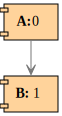

In [1]:
from heterograph.query.qgraph import QGraph

QGraph(pattern='A => B').view()

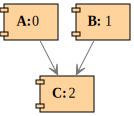

In [2]:
QGraph(pattern='(A | B) => C').view()

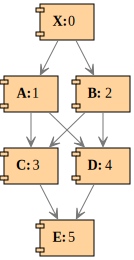

In [3]:
QGraph(pattern='X=>(A|B)=>(C|D)=>E').view()

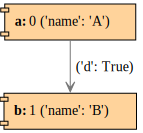

In [4]:
QGraph(pattern='a{name:"A"} ={d:True}>b{name:"B"}').view()

## Query Processor DFS

The `QueryProcessorDFS` class is utilized to identify specific subgraph patterns within a larger, arbitrary graph (`HGraph`). After creating an instance of this class, the `run` method can be invoked with the appropriate parameters to execute the search:
- `g`: This is the graph to be queried. It should be an instance of HGraph.
- `qgraph`: This is the query graph, an instance of QGraph, which represents the pattern you're looking for in the main graph.
- `vs`: This is a list of vertices from which the query should start (roots)
- `path_check`: This is a function that checks the validity of a path. It should take a path as input and return a boolean indicating whether the path is valid.
- `match_filter`: This is a function that filters the matches. It should take a match as input and return a boolean indicating whether the match should be included in the results.
- `fd`: This is an optional parameter that specifies the distance between the root (specified in `vs`) and first node of a match. It can be an integer or a tuple of two integers. If it is an integer, the distance must be exactly that integer. If it is a tuple, the distance must be within the range specified by the tuple.
- `gd`: This is an optional parameter that specifies the distance between the root (specified in `vs`) and any node of a match. It can be an integer or a tuple of two integers. If it is an integer, the distance must be exactly that integer. If it is a tuple, the distance must be within the range specified by the tuple.

As an example, consider the following graph where each vertex has a label and a type (circle or rect).

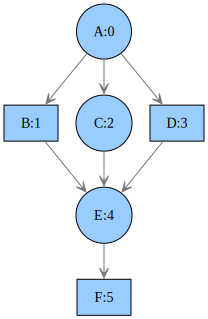

In [5]:
from heterograph import *

g = HGraph()
for i in range(0, 6):
    vx = g.add_vx()
    g.pmap[vx]['name'] = chr(i+ord('A'))
    g.pmap[vx]['type'] = "circle" if i % 2 == 0 else "rect"

    g.vstyle['label'] = lambda g, vx: f"{g.pmap[vx]['name']}:{vx}"
    g.vstyle['shape'] = lambda g, vx: g.pmap[vx]['type']

g.add_edge(0, [1, 2, 3])
g.add_edge([1,2,3], 4)
g.add_edge(4, 5)
g.view()

For our example, we develop a query system that matches specific constraints, namely label and type. The initial step in this process involves transferring AQL arguments into the vertices of the query graph. For this, we create the `vx_args` function which is be passed to `QGraph` constructor when we create a query.

In [6]:
# we will pass this function when we create a QGraph
def vx_args(qg, vx, *, name=None, type=None):
    qg.pmap[vx]['name'] = name
    qg.pmap[vx]['type'] = type

Next, we set up the query processor. This involves defining two optional functions: `path_check` and `match_filter`. The `path_check` function is used to verify if any two vertices from the query graph correspond to two vertices in the main graph. If `True` then then become part of the match. The `match_filter` function is used to filter out the complete matches based on certain criteria. 

In our example, we use `path_check` to check if vertex constraints, such as name or type match.

In [7]:
from heterograph.query.processor_dfs import QueryProcessorDFS

def path_check(g, qg, gchain, qgchain):
    # This allows for a comparison between two vertices that form a path (q_vpair) and
    # two vertices from the query graph (g_vpair). For example, it can be used to
    # implement distance constraints between two vertices. In this case, we check the
    # vertex contraints match

    vx = gchain[1]
    qvx = qgchain[1]

    for attr in ['name', 'type']:
        if qg.pmap[qvx][attr] is not None:
            # match the exact attribute value, we could
            # use regex or other matching
            if g.pmap[vx][attr] != qg.pmap[qvx][attr]:
                return False

    return True

processor = QueryProcessorDFS()

Now, let us create a query: find all `circle` vertices.

In [8]:
qg=QGraph('x{type:"circle"}', vx_args=vx_args)

matches=processor.run(g, qg, path_check=path_check)
print(matches)

[{'x': 4}, {'x': 4}, {'x': 2}, {'x': 4}, {'x': 0}]


Each match corresponds to a mapping from a vertex in the query graph (qgraph) to a vertex in the main graph. It is important to note, as shown above, that duplicates may occur. For this purpose, the `QueryResultSe`t class is used to refine these results and optionally perform actions on them. One such action is the removal of identical results, which can be achieved using the `RSet::distinct` method.

In [9]:
from heterograph.query.resultset import QueryResultSet
from heterograph.query.rsutils import RSet

qrs = QueryResultSet(g, qg, matches)
qrs = RSet.distinct(qrs)
print(qrs)

  x
---
  4
  2
  0


Now, let us do a more complex query and find a circle vertex connected to a vertex of any type.

In [10]:
qg=QGraph('x{type:"circle"}=>y', vx_args=vx_args)

matches=processor.run(g, qg, path_check=path_check)
RSet.distinct(QueryResultSet(g, qg, matches))

  x    y
---  ---
  4    5
  2    5
  2    4
  0    5
  0    4
  0    1
  0    2
  0    3

Please note that each entry in the list of matches is independent. Furthermore, although the distance between vertices `x` and `y` is not explicitly constrained, it is guaranteed that `y` is part of the path when `x` is visited. To specify distance constraints, you can add a constraint to the edge in the query graph (qgraph). The `eg_args` parameter can then be used to translate AQL edge arguments into the qgraph edge property map, similar to how `vx_args` is used for vertices.

The `QueryProcessorDFS` class includes two optional global parameters, `fd` and `gd`, which filters out matches.

The `fd` parameter is a tuple (min, max) that defines the minimum and maximum distance between the root vertex, where the search begins, and the first element found in the match. If a single integer `d` is provided, it is interpreted as both the minimum and maximum distance.

For the above example, the search starts with root vertex 0 ("A"). So if we specify fd=1, then we have:

In [11]:
# without "fd" constraint
matches=processor.run(g, qg, path_check=path_check)
print(RSet.distinct(QueryResultSet(g, qg, matches)))

# with fd=1. x=2 is exactly 1 edge away from the root vertex 0
matches=processor.run(g, qg, path_check=path_check, fd=1)
RSet.distinct(QueryResultSet(g, qg, matches))

  x    y
---  ---
  4    5
  2    5
  2    4
  0    5
  0    4
  0    1
  0    2
  0    3


  x    y
---  ---
  2    5
  2    4

On the other hand, the `gd` parameter follows the same distance type as `fd`, that is (int,int) or int. It provides the distance between root vertex 0 ("A") where the search starts and any node in a match. In this example, we specify the `gd` distance between (0, 2). 

In [12]:
# without "gd" constraint
matches=processor.run(g, qg, path_check=path_check)
print(RSet.distinct(QueryResultSet(g, qg, matches)))

# with gd=(0, 2). Note that (4, 5) and (2, 5), for instance, do not meet the distance constraint
# since vertex 5 has a distance of 3 from the root vertex 0.
matches=processor.run(g, qg, path_check=path_check, gd=(0, 2))
RSet.distinct(QueryResultSet(g, qg, matches))

  x    y
---  ---
  4    5
  2    5
  2    4
  0    5
  0    4
  0    1
  0    2
  0    3


  x    y
---  ---
  2    4
  0    4
  0    1
  0    2
  0    3